# Captcha Data Cleaning and EDA

### Imports

In [1]:
import string
import os

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline 

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
tf.__version__, cv2.__version__

('2.1.0', '4.2.0')

## Data Cleaning

### Load Data

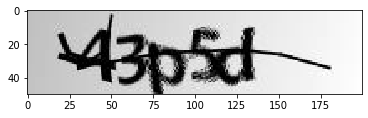

In [5]:
# example from 1000 image dataset
simg=cv2.imread('data/s_data/43p5d.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(simg, cmap=plt.get_cmap('gray'))

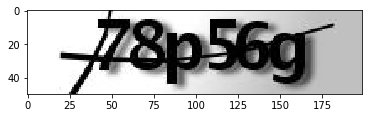

In [6]:
# example from AWS website
img=cv2.imread('trial.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

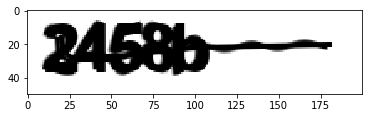

In [7]:
# example from 100,000 image dataset 
img=cv2.imread('data/l_data/2458b.png', cv2.IMREAD_UNCHANGED)[:,:,3]

# remove border 
img[[0,49],1:199] -= 255
img[:,0] -= 255
img[:,199] -= 255

plt.imshow(img, cmap=plt.cm.binary)

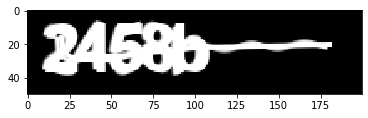

In [8]:
# for anti grayscale
img=cv2.imread('data/l_data/2458b.png',cv2.IMREAD_UNCHANGED)
a = img[:,:,3]
lst = []

for i in a.flatten():
    lst.append(np.abs(i - 255))
lst = np.array(lst)
img = lst.reshape(50, 200)

img[[0,49],1:199] += 255
img[:,0] += 255
img[:,199] += 255

plt.imshow(img, cmap=plt.cm.binary)

### Removing Border and Create Target

In [9]:
# check data folders for non image files
def s_data_check(from_src=False):
    '''Check for non PNG files
    '''
    if from_src:
        path = '../data/s_data/'
    else:
        path = 'data/s_data/'
        
    for name in os.listdir(path):
        if name[-4:] == '.png' or name[-4:] == '.jpg':
            pass
        else:
            print(name)
        
def l_data_check(from_src=False):
    '''Check for non PNG files
    '''
    if from_src:
        path = '../data/l_data/'
    else:
        path = 'data/l_data/'
        
    for name in os.listdir(path):
        if name[-4:] == '.png':
            pass
        else:
            print(name)

In [10]:
s_data_check() # should not print anything

In [11]:
l_data_check() # should not print anything

In [5]:
chars = string.ascii_lowercase + "0123456789"
num_chars = len(chars)

In [6]:
# image data processing functions

def remove_img_border(img):
    # remove border
    img[[0,49],1:199] -= 255
    img[:,0] -= 255
    img[:,199] -= 255
    
    return img
    
def l_data_process(from_src=False):
    '''Processes the l_data folder of 109,053 images 
    Parameters:
    -----------
    from_src: True if function is run from src folder
    
    Returns:
    X: 4 tensor numpy array of image data
    y: One hot encoded targets
    labels: labels for image data
    '''
    if from_src:
        path = '../data/m_data/'
    else:
        path = 'data/m_data/'
        
    X = np.zeros((len(os.listdir(path)), 50, 200, 1)) 
    y = np.zeros((5, len(os.listdir(path)), num_chars)) 
    labels = []
    
    for i, name in enumerate(os.listdir(path)):
        img_path = path + name
        img = cv2.imread(img_path , cv2.IMREAD_UNCHANGED)[:,:,3]
        
        img = remove_img_border(img)
        img = img / 255.0
        img = img.reshape(50, 200, 1)
        
        # Define labels using OneHotEncoding
        label = name[:-4]
        target = np.zeros((5, num_chars))
        for j, l in enumerate(label):
            ind = chars.find(l)
            target[j, ind] = 1
        
        X[i] = img
        y[:, i] = target
        labels.append(label)
   
    return X, y, labels

def s_data_process(from_src=False):
    '''Processes the s_data folder of 1070 images 
    Parameters:
    -----------
    from_src: True if function is run from src folder
    
    Returns:
    X: 4 tensor numpy array of image data
    y: One hot encoded targets
    labels: labels for image data
    '''
    if from_src:
        path = '../data/s_data/'
    else:
        path = 'data/s_data/'
        
    X = np.zeros((len(os.listdir(path)), 50, 200, 1)) 
    y = np.zeros((5, len(os.listdir(path)), num_chars))
    labels = []
    
    for i, name in enumerate(os.listdir(path)):
        img_path = path + name
        img = cv2.imread(img_path , cv2.IMREAD_GRAYSCALE)
        
        img = img / 255.0
        img = img.reshape(50, 200, 1)
        
        # Define labels using OneHotEncoding
        label = name[:-4]
        target = np.zeros((5, num_chars))
        for j, l in enumerate(label):
            ind = chars.find(l)
            target[j, ind] = 1
        
        X[i] = img
        y[:, i] = target
        labels.append(label)
   
    return X, y, labels

In [22]:
s_X, s_y, s_labels = s_data_process()
s_X.shape, s_y.shape

((1070, 50, 200, 1), (5, 1070, 36))

In [80]:
s_y[0].shape

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
X, y, llabels = l_data_process()
X.shape, y.shape

((89661, 50, 200, 1), (5, 89661, 36))

In [8]:
X[0].shape, y[:, 0].shape

((50, 200, 1), (5, 36))

In [30]:
# contours doesn't work with connected characters...

## Exploratory Data Analysis

In [193]:
slst_of_chars = []
for s in s_y:
    slst_of_chars += [char for char in s]
len(slst_of_chars)/1070, len(slst_of_chars)

(5.0, 5350)

In [196]:
#pd.Series(slst_of_chars).value_counts().sort_index();

In [ ]:
lst_of_chars = []
for s in l_y:
    lst_of_chars += [char for char in s]
len(lst_of_chars)/109053, len(lst_of_chars)

In [ ]:
# Character Distribution for Large Image Dataset
pd.Series(lst_of_chars).value_counts().sort_index()

In [37]:
def remove_grid_lines(axs):
    """Remove the default grid lines from a collection of axies."""
    for ax in axs.flatten():
        ax.grid(False)

In [177]:
def apply_convolution_to_image(image,
                               image_shape=(50, 200),
                               filter_shape = (5, 5)):
    """Apply a convolutional filter to an image.  The inputs here should be
    numpy arrays, this function will take care of converting them to tensors
    and back.
    """

    image_tensor = image.reshape(1, image_shape[0], image_shape[1], 1)
    #filter_tensor = convolutional_filter.reshape(filter_shape[0], filter_shape[1], 1, 1)
    
    
    x = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu')(x)
    #x = layers.MaxPooling2D(padding='same')(x)
    
    image_convloved = x[0, :, :, 0]
    return image_convloved

In [168]:
def apply_max_pool_to_image(image, 
                            image_shape=(50,200), 
                            filter_shape = (2, 2)):
    image_tensor = image.reshape(1, image_shape[0], image_shape[1], 1)
    image_pooled_tensor = tf.nn.max_pool(
        image_tensor, 
        ksize=[1, 2, 2, 1], 
        strides=[1, 2, 2, 1], padding='SAME')
    image_pooled = image_pooled_tensor[0, :, :, 0]
    return image_pooled

In [178]:
# example from 100,000 image dataset 
img=cv2.imread('data/m_data/y223e.png', cv2.IMREAD_UNCHANGED)[:,:,3]

# remove border 
img = remove_img_border(img)
img = img / 255.0

blurred = apply_convolution_to_image(img)
pooled = apply_max_pool_to_image(img)

In [158]:
def plot_convolution(before, after, axs):
    """Plot a 1 by 3 grid of images:
        - A before image.
        - A filter to apply.
        - The result of convolving the filter with the image.
    """
    axs[0].imshow(before, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[0].set_title("Before")
    axs[1].imshow(after, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[1].set_title("After")

In [164]:
blurred.shape, pooled.shape

(TensorShape([50, 200]), TensorShape([25, 100]))

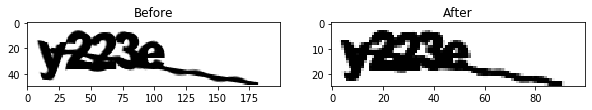

In [191]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8))

plot_convolution(img, pooled, axs)
remove_grid_lines(axs)

# after Max Pooling

### Look at Layer Weights

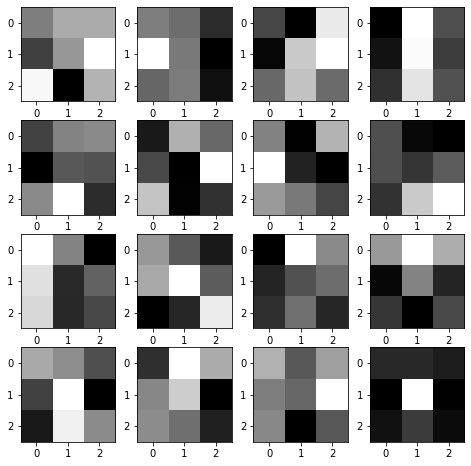

In [187]:
weights1_np = model.get_weights()[0] # 5 5 1 16

fig, axs = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axs.flatten()):
    filter = weights1_np[:, :, 0, i]
    ax.imshow(filter, cmap=plt.cm.gray_r, interpolation="nearest")
remove_grid_lines(axs)

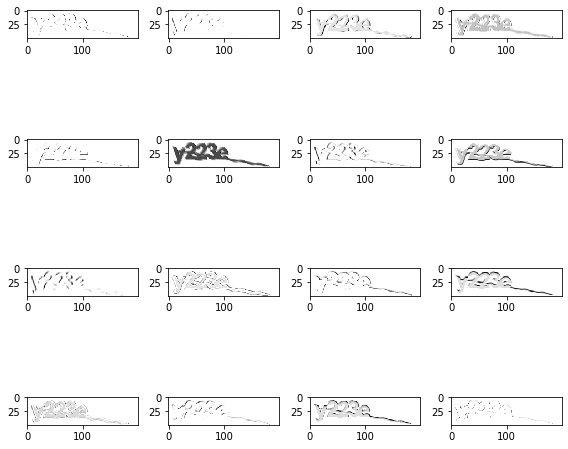

In [188]:
zero_tensor = tf.constant(img.reshape(1, 50, 200, 1))
zero_activations = tf.nn.conv2d(
    zero_tensor, weights1_np, strides=[1, 1, 1, 1], padding='SAME'
)
# or keras.activations.relu(zero_activations)
zero_activations_relu = np.maximum(zero_activations,0) 
# plot
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(zero_activations_relu[0, :, :, i],
              cmap=plt.cm.gray_r, interpolation="nearest")
remove_grid_lines(axs)
plt.tight_layout()

## Split Data

#### Small Image Dataset

In [81]:
s_X.shape, s_y.shape

((1070, 50, 200, 1), (5, 1070, 36))

In [82]:
sX_train, sy_train = s_X[:900], s_y[:, :900]
sX_test, sy_test = s_X[900:], s_y[:, 900:]

##### Try

In [ ]:
sX_train, sX_test, sy_train, sy_test = train_test_split(s_X, s_y, test_size=0.2, random_state=7)

In [37]:
sX_train.shape, sX_test.shape, sy_train.shape, sy_test.shape

((856, 50, 200), (214, 50, 200), (856,), (214,))

In [38]:
sX_train[0].shape

(50, 200)

#### Large Image Dataset

In [9]:
X.shape, y.shape

((89661, 50, 200, 1), (5, 89661, 36))

In [10]:
X_train, y_train = X[:77777], y[:, :77777]
X_test, y_test = X[77777:88888], y[:, 77777:88888]
Xer, yer = X[88888:], y[:, 88888:]

##### Try

In [74]:
lX_train, lX_test, ly_train, ly_test = train_test_split(l_X, l_y, test_size=0.2, random_state=7)

In [41]:
lX_train.shape, lX_test.shape, ly_train.shape, ly_test.shape

((71728, 50, 200), (17933, 50, 200), (71728,), (17933,))

In [42]:
lX_train[0].shape

(50, 200)

## Build Model

In [15]:
input_shape = (50, 200, 1)

def create_model():
    # Input layer
    img = layers.Input(shape=input_shape)
    
    # Convolution and Max Pooling Layers
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    
    flat = layers.Flatten()(mp1)
    output = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        result = layers.Dense(num_chars, activation='sigmoid')(drop)

        output.append(result)
    
    # Compile model and return it
    model = Model(img, output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model

In [16]:
model = create_model();
model.summary();

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50, 200, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 50, 200, 16)  160         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 25, 100, 16)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 40000)        0           max_pooling2d_2[0][0]            
____________________________________________________________________________________________

In [17]:
X_train.shape

(77777, 50, 200, 1)

In [18]:
history = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]],
                 batch_size=256, epochs=10,verbose=1, validation_split=0.2)

Train on 62221 samples, validate on 15556 samples
Epoch 1/10
62221/62221 [==============================] - 19s 310us/sample - loss: 12.6785 - dense_21_loss: 1.8505 - dense_23_loss: 2.3895 - dense_25_loss: 2.6871 - dense_27_loss: 2.8404 - dense_29_loss: 2.8942 - dense_21_accuracy: 0.4341 - dense_23_accuracy: 0.2786 - dense_25_accuracy: 0.1754 - dense_27_accuracy: 0.1517 - dense_29_accuracy: 0.1043 - val_loss: 5.6446 - val_dense_21_loss: 0.0316 - val_dense_23_loss: 0.6331 - val_dense_25_loss: 1.1239 - val_dense_27_loss: 1.7667 - val_dense_29_loss: 2.0893 - val_dense_21_accuracy: 0.9999 - val_dense_23_accuracy: 0.8922 - val_dense_25_accuracy: 0.7285 - val_dense_27_accuracy: 0.5781 - val_dense_29_accuracy: 0.2255
Epoch 2/10
62221/62221 [==============================] - 15s 244us/sample - loss: 6.3893 - dense_21_loss: 0.4298 - dense_23_loss: 0.8851 - dense_25_loss: 1.3730 - dense_27_loss: 1.7950 - dense_29_loss: 1.9026 - dense_21_accuracy: 0.8356 - dense_23_accuracy: 0.6938 - dense_25_acc

In [377]:
model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)

11111/11111 [==============================] - 2s 223us/sample - loss: 0.2612 - dense_72_loss: 1.2036e-05 - dense_74_loss: 0.0058 - dense_76_loss: 0.0563 - dense_78_loss: 0.1548 - dense_80_loss: 0.0438 - dense_72_accuracy: 1.0000 - dense_74_accuracy: 0.9988 - dense_76_accuracy: 0.9833 - dense_78_accuracy: 0.9527 - dense_80_accuracy: 0.9900
Test Loss and accuracy: [0.26116753493153794, 1.2036429e-05, 0.0057882736, 0.05632737, 0.15475263, 0.043789554, 1.0, 0.99882996, 0.98325986, 0.95274955, 0.9900099]


In [378]:
model.evaluate(Xer,[yer[0], yer[1], yer[2], yer[3], yer[4]])

773/773 [==============================] - 0s 236us/sample - loss: 0.2902 - dense_72_loss: 1.2918e-06 - dense_74_loss: 0.0071 - dense_76_loss: 0.0572 - dense_78_loss: 0.1796 - dense_80_loss: 0.0382 - dense_72_accuracy: 1.0000 - dense_74_accuracy: 0.9974 - dense_76_accuracy: 0.9793 - dense_78_accuracy: 0.9457 - dense_80_accuracy: 0.9858


[0.29023477375835066,
 1.2918393e-06,
 0.007113537,
 0.057221554,
 0.17959958,
 0.038234353,
 1.0,
 0.9974127,
 0.97930145,
 0.94566625,
 0.98576975]

In [19]:
yer[:,1].shape

(5, 36)

In [29]:
def predict_lots(X_test, y_test):
    co = 0
    bad = 0
    for i, img in enumerate(X_test):
    
        img = img.reshape(1, 50, 200, 1)

        true = ''
        for j in yer[:,i]:
            c = chars[np.argmax(j)]
            true += c

        onehotpred = np.array(model.predict(img)).reshape(5,36)    
        pred = ''

        for i in onehotpred:
            c = chars[np.argmax(i)]
            pred += c

        #print(true, pred)
        co +=1
        if true == pred:
            bad += 1
            
    print(bad, co)

In [30]:
predict_lots(Xer, yer)

657 773


In [31]:
657/773

0.8499353169469599

In [23]:
predict_lots(s_X, s_y)

nbxpw regra
k6gpg fcyw6
8nf6f frrw6
cwfr6 fry32
da6dn fdxwd
a428n fcypg
p38nd ffxyd
5w3ag feaw3
2karc fwawg
yayn3 fkyy2
2w243 fryy3
78bk3 rrey3
4bwx5 rmay2
bxhec fr3w6
m2h74 frxya
6wcxf feny2
6cmpb ffac2
dk46f fkxw2
p86fn fcxw6
dw332 fcxx6
ppr64 rwmw6
mem4x f3xyy
8f6ck fecyd
r7cnx ffy32
ahp74 rkacg
7kngf feryg
6gxh5 frxw2
pbh6r f3yyy
5m3ar cyy32
wx7m5 f8yy3
r3nre frxy2
4mxer fkxw2
h4d3y fexy2
fhxxe xkyra
efcw6 fky32
yydge fryy6
67667 frxp2
cga7d frcc2
m26p6 fe3yg
7exeb frnmg
b5c7x cygxa
wnwac f3xwy
n68he fmrgg
prkfn frawg
rm8pg f57w2
fk2dx rkywg
4adwr rrey2
fhyxd frgy3
f2b4x fppx2
ean4f f8gm6
rxf2y rry56
ymydc frxyg
yaxyy frxw2
e8n2e frxw2
rhhcp r3yyg
ex8k3 m35y2
3g4fk ecpwy
w5y4m fcxmg
8r72k f64y2
66r4g f8y73
k2r4e fpym5
xccyc fr3p2
4543m fryc2
hhh7c frpwy
68eey mcryg
bcpk7 crymg
2gmgg f8yyg
bg4wp f8yw2
6amy2 fmywg
mcnhr fk4y2
3hn62 fcaay
64n8r rryy3
66dp6 frwxx
cy4dh fkyry
krg83 ff2y2
hxxbd fkmy7
6b5hy frmyg
22xf8 f73y2
p6ddf frrw2
64na5 frayg
e3ang fk8dc
md4nm frmyy
hy536 fk5yg
52y7

fwam3 fprx3
65kwd fcywy
4gckf f8py2
w7rad feyy6
4dnnf fryc3
rrdnp fp2p2
4cah7 mkyya
mwbgh f3ry6
rr4ky cryy2
8p3hk fpyx5
bydkw fkxy3
nbmgk rpy32
xdxac fce3y
rpr3e fexyg
am846 frxw3
r846f fmycg
rbkca ekyw2
bd6k6 7ryc2
mxkw7 fryyg
exn4r fpxw6
exh5x fr733
hbmea frgp2
dmye8 fkyy2
k3rp4 fyew2
nmpaa fry7g
wafa3 fpc3p
w8bfp fx4w2
wd6ff frxy6
e2cb2 fccw2
b8fe5 fkyyy
rn5xn fk33g
6admf frawy
3bnbw frx5g
4rwr4 fkyyg
y45w7 fr7y6
6ny2d fceya
gmyxr fcwwy
kyc5h fray5
2xm4e frwya
3x7p3 fryy6
yr6bk ffyy6
re48x frap3
mx527 frey2
grpwh frxc3
kbkya rrawa
nxkyh fryx2
472d2 fkxwa
yf7mx fc332
5537e rk7y2
58gpf frpmp
636fy camyk
hhawa fkw33
x4484 fr5yg
febec mcyyg
rbk64 fkaw2
h5bd3 f74w3
5np27 frry6
apyr6 f3xy2
fep3c fcm32
657pb fcxy6
frpwg f63y3
xpdx8 fp5ck
5n5nm fkmwa
d4xw7 r3yya
d5362 7cey2
2mmx8 rbxy2
264h7 r8yyg
8cehy rryyg
bn2x6 fyyyg
xbgdf fmmyg
h32w2 fkyw3
6rcmf fway2
dpmpb fryeg
mkk8y rcry6
6ypm5 frx5d
chrwf fexxd
n7gf6 fcnwy
kh56x frry3
ekm2g fw4x2
7e5rx fkxy2
24krg fry32
wgm53 fyryg
h2wmm fe3p2
ky2b

IndexError: index 773 is out of bounds for axis 1 with size 773

In [385]:
def predict_one(img_path):
    img = cv2.imread(img_path , cv2.IMREAD_UNCHANGED)[:,:,3]
        
    # remove border
    img = remove_img_border(img)
    
    img = img / 255.0
    img = img.reshape(1, 50, 200, 1)
    
    true = img_path[-9:-4]
    
    onehotpred = np.array(model.predict(img)).reshape(5,36)    
    pred = ''
    
    for i in onehotpred:
        c = chars[np.argmax(i)]
        pred += c

    return true, pred

In [386]:
img_path = 'data/m_data/y223e.png'
print(predict_one(img_path))

('y223e', 'y223e')


In [344]:
Xer[0].shape

(50, 200, 1)

In [33]:
img_path = 'trial.png'
img = cv2.imread(img_path , cv2.IMREAD_UNCHANGED)[:,:,0] #cv2.IMREAD_GRAYSCALE)   

flatimg = pd.Series(img.flatten()) 
flatimg = flatimg.apply(lambda x: 255 if x > 50 else x)
flatimg = flatimg.apply(lambda x: np.abs(x - 255))
flatimg = flatimg.values.reshape(50,-1)

In [34]:
flatimg.shape

(50, 199)

In [35]:
flatimg = np.hstack((flatimg, np.repeat(0,50).reshape(50,1)))

In [36]:
#pd.Series(flatimg.flatten()).value_counts()

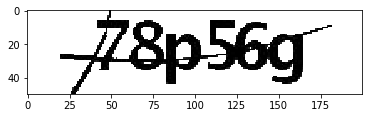

In [37]:
plt.imshow(flatimg, cmap=plt.cm.binary)

In [38]:
img = flatimg.copy()
img[:, :61] = 0
img = img[:, 50:]

In [39]:
img = np.hstack((img, np.repeat(0,2500).reshape(50,-1)))

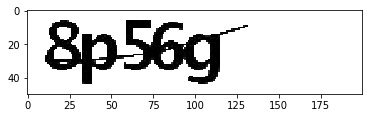

In [40]:
plt.imshow(img, cmap=plt.cm.binary)

In [41]:
img = img / 255.0
img = img.reshape(1, 50, 200, 1)

In [44]:
true = '8p56g'

onehotpred = np.array(model.predict(img)).reshape(5,36)    
pred = ''

for i in onehotpred:
    c = chars[np.argmax(i)]
    pred += c

#print(true, pred)